# Assignment 4 - DDPG

During labs you have learnt about DQN - an algorithm for solving discrete action environments.
In this task you will implement DDPG which can be thought of as DQN variation for environments with continuous action space.

You should implement missing parts of the training loop which are annotated with the following comment:
```
#########################
### TODO - YOUR CODE ####
#########################
```



Here is the pesudocode from the original work: 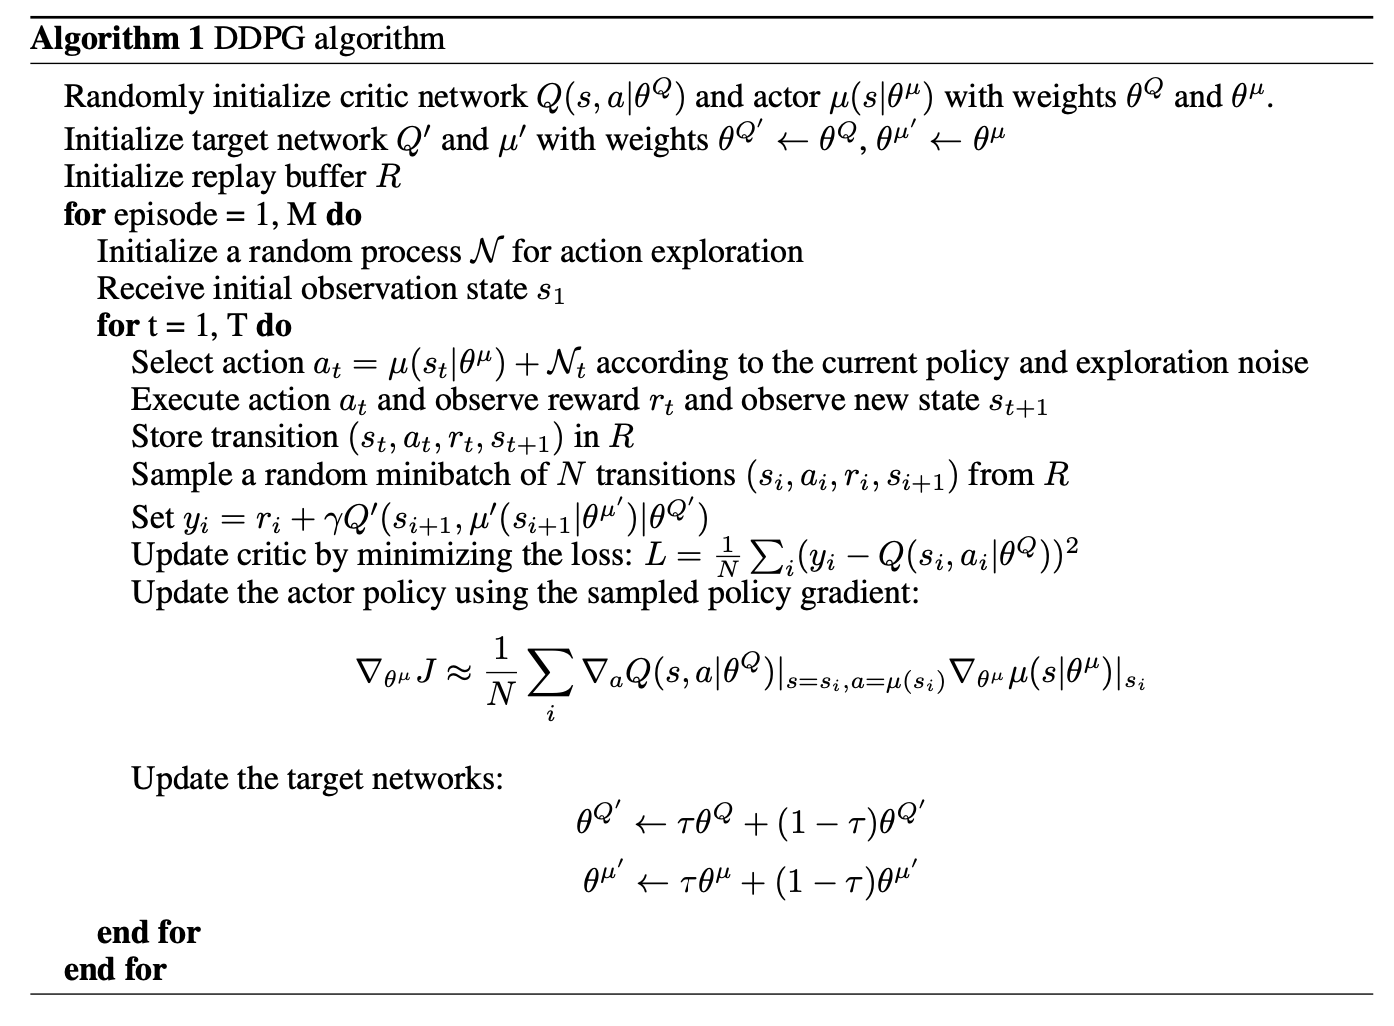

### Resources

- [openai/gym](https://gym.openai.com/docs/)
- [getting-started-with-openai-gym](https://blog.paperspace.com/getting-started-with-openai-gym/)
- [Continuous control with deep reinforcement learning (DDPG)](https://arxiv.org/abs/1509.02971)
- [Deterministic Policy Gradient Algorithms](http://proceedings.mlr.press/v32/silver14.pdf)

You can read about actor policy update step and how to implement it here:
- https://www.quora.com/Why-is-the-loss-for-DDPG-Actor-the-product-of-gradients-of-Q-values-actions
- https://stackoverflow.com/questions/51496159/ddpg-deep-deterministic-policy-gradients-how-is-the-actor-updated


## Requirements

1. Experiments reproducability:

    You should ensure that you can re-run your experiments and obtain the same results. To do so implement `set_seed` function that handles necessary logic. Pick one of the experiments (short one) and re-run it with logging of the losses/mean_rewards to show that results are reproduced.

2. Implement Polyak average for updating network's parameters:

    During labs about DQN you have seen that target's network parameters can be updated every K steps by overwritting old parameters. There are other, more robust, methods to do so. One of the most popular is polyak average (weighted moving average). Your tasks will be to implement it as well.

3. Implement DDPG algorithm:

    Read paper carefully, and don't forget about exploration.

4. Environments:

    Solve the environmets listed below and reach the corresponding benchmark score.

5. Analysis of different hyperparameters.

    Pick one of the environments and repeat the training 5 times with a different subset of hyperparameters such that the results differ. Present comparison of used parameters' configurations, training summary, plots, and your conclusions.

    Tip: RL algorithms are especially parameter sensitive. It's a good occasion to ponder how to organize your work such that you can easily track and compare different runs and configurations. Organize your experiments or use a utility such as [tensorboard](https://pytorch.org/docs/stable/tensorboard.html), [neptune](neptune.ai), [wandb](wandb.ai) or [clearml](https://clear.ml/).


### Evaluation & Grading

Total points: 12
- Seed initalization & experiment reproducibility [0.5]
- Polyak average [0.5]
- Gaussian noise [0.5]
- DDPG [5.5]
- Solving environments (benchmark) [3.0]
- Analysis of different hyperparameters [2.0]

#### Benchmark
For each of the following environments you should train one agent and obtain at least the following mean score in our benchmark:
```
"Pendulum-v1" : -160,
"LunarLanderContinuous-v2": 130,
"MountainCarContinuous-v0": 80
```



Tips:
- Study environment's action space and ensure that your cover the whole range. Perhaps Tanh activation could be useful?
- Adding noise to the action can take you out of the environment's action space. Ensure that the final action is valid before calling `env.step(action)`.
- RL agents tend to forget previously learnt behaviors, especially if algorithm is not very stable. Therefore, it's a good practice to evaluate and save checkpoints (weights of the model) every K-th steps. You can later load the best set of parameters.
- Here are a few statistics that are usefull to track your training progress:
```
logs = {
    "episodes_rews": [],
    "episodes_lens": [],
    "critic_losses": [], 
    "actor_losses": []
}
```
For example, it's useful to log mean episode reward for last 50 episodes.

# Environment setup, helper functions & classes

Remember to restart your runtime after installing the packages.

In [38]:
!pip3 install 'gym==0.21.0' > /dev/null 2>&1
!pip3 install box2d-py==2.3.8 > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip3 install ez_setup > /dev/null 2>&1
!pip3 install gym[atari] > /dev/null 2>&1
!pip3 install gym[Box_2D] > /dev/null 2>&1
!pip3 install pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.* > /dev/null 2>&1
!pip install clearml > /dev/null 2>&1

In [39]:
import copy
import random
import numpy as np
import torch
import torch.nn as nn
from typing import List, Optional, Callable, Tuple
from collections import namedtuple
import imageio
from pathlib import Path
import gym
from pyvirtualdisplay import Display

In [46]:
import plotly.express as px
import plotly.graph_objects as go

In [48]:
import pandas as pd

In [40]:
from clearml import Task

web_server = 'https://app.community.clear.ml'
api_server = 'https://api.community.clear.ml'
files_server = 'https://files.community.clear.ml'
access_key = ' AK85VJ3VTN3OZH2Q9YXL'#@param {type:"string"}
secret_key = ' xP7mTbqfGKOn2UjsZheGiRPSUfUXqdOJQA4LNYQHvuX1Kq3CZ2'#@param {type:"string"}

Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)

### Benchmark

Don't modify Benchmark's cell. Your solution should pass the proposed thresholds.

In [5]:
def as_tensor(data: np.ndarray, dtype=torch.float32, batch: bool = False) -> torch.Tensor:
    tensor = torch.tensor(data, dtype=dtype, device=DEVICE)
    if batch and len(tensor.shape) == 1:
        tensor = tensor.unsqueeze(dim=1)
    return tensor

class Benchmark:
    def __init__(self):
        """ Don't modify. Your agent should pass those benchmarks. """
        self.env_to_mean_score = {
            "Pendulum-v1" : -160,
            "LunarLanderContinuous-v2": 130,
            "MountainCarContinuous-v0": 80
        }
        self.n_episodes = 100
        self.seed = 42
    
    def run(self, env_id: str, policy) -> None:
        env = gym.make(env_id)
        stats = self._eval(env, policy, self.n_episodes, self.seed)
        score = np.mean(stats["episodes_rews"])
        result = "Success" if score > self.env_to_mean_score[env_id] else "Failure"
        print(f"{result} on {env_id} with mean score: {score}")
        assert len(stats["episodes_rews"]) == self.n_episodes

    def _eval(self, env, policy, n_episodes: int = 100, seed: Optional[int] = None):
        print("\nStarting Benchmark:")
        print("seed:", seed)
        print("n_episodes:", n_episodes)
        if seed: # Be careful, this will reset your rng!
            set_seeds(env, seed)

        stats = {
            "episodes_rews": [],
            "episodes_lens": [],
        }
        
        for episode in range(n_episodes):
            done = False
            obs = env.reset()
            ep_rew, ep_len = 0, 0

            while not done:
                with torch.no_grad():
                    action = policy(as_tensor(obs)).numpy() # No exploration noise during evalution!
                obs, reward, done, _ = env.step(action)
                ep_rew += reward
                ep_len += 1
            
            stats["episodes_lens"].append(ep_len)
            stats["episodes_rews"].append(ep_rew)

        print("Rewards:", stats["episodes_rews"])
        print("Lengths:", stats["episodes_lens"])
        print("Mean episode reward:", np.mean(stats["episodes_rews"]))
        print("Mean episode length:", np.mean(stats["episodes_lens"]))

        return stats

### Utilities

A few helper functions to help you get started.

In [6]:
def eval(env, policy, n_episodes: int = 100, seed: Optional[int] = None):
    """ Helper method to evaluate agent """
    if seed: # Be careful, this will reset your rng!
        set_seeds(env, seed)

    stats = {
        "episodes_rews": [],
        "episodes_lens": [],
    }
    
    for episode in range(n_episodes):
        done = False
        obs = env.reset()
        ep_rew, ep_len = 0, 0

        while not done:
            with torch.no_grad():
                action = policy(as_tensor(obs)).numpy() # No exploration noise during evalution
            obs, reward, done, _ = env.step(action)
            ep_rew += reward
            ep_len += 1
        
        stats["episodes_lens"].append(ep_len)
        stats["episodes_rews"].append(ep_rew)

    print("Rewards:", stats["episodes_rews"])
    print("Lengths:", stats["episodes_lens"])
    print("Mean episode reward:", np.mean(stats["episodes_rews"]))
    print("Mean episode length:", np.mean(stats["episodes_lens"]))

    return stats

In [7]:
def make_gif(env_id, actor = None, n_episodes: int = 1, gif_name: str = "agent.gif", dir: str = "./gifs"):
    """ 
    Create a gif of an agent interacting with an environment.
    Note: It does not always work in Google colab, and crashes from time to time.
    """
    display = Display(visible=0, size=(1400, 900))
    display.start()

    Path(dir).mkdir(parents=True, exist_ok=True)
    filename = Path(dir).joinpath(gif_name)

    images = []
    env = gym.make(env_id)
    for _ in range(n_episodes):
        obs, done = env.reset(), False
        images.append(env.render("rgb_array"))
        while not done:
            if actor:
                with torch.no_grad():
                    action = actor(as_tensor(obs)).numpy()
            else:
                action = env.action_space.sample() 
            obs, reward, done, _ = env.step(action) 
            images.append(env.render("rgb_array"))

    imageio.mimsave(filename, images, fps=29)

In [8]:
def try_gpu(i: int = 0) -> None:
    """ Return gpu(i) if exists, otherwise return cpu() """
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In gym environments Box(n,) corresponds to the n-dimensional continuous space. The observation space has upper and lower bounds that describe the range of values it can take.

In [9]:
def describe_env(env_id: str) -> None:
    print(env_id)
    env = gym.make(env_id)
    spec = gym.spec(env_id)
    print(f"Environment: {env_id}")
    print(f"Observation Space: {env.observation_space}")
    print(f"Observation Space High: {env.observation_space.high}")
    print(f"Observation Space Low: {env.observation_space.low}")
    print(f"Action Space: {env.action_space}")
    print(f"Max Episode Steps: {spec.max_episode_steps}")
    print(f"Nondeterministic: {spec.nondeterministic}")
    print(f"Reward Range: {env.reward_range}")
    print(f"Reward Threshold: {spec.reward_threshold}")

continuous_envs = ["Pendulum-v1", "LunarLanderContinuous-v2", "MountainCarContinuous-v0"]

print(80*"#" + "\n")
for i, env in enumerate(continuous_envs):
    describe_env(env)
    print("\n" + 80*"#" + "\n")

################################################################################

Pendulum-v1
Environment: Pendulum-v1
Observation Space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Observation Space High: [1. 1. 8.]
Observation Space Low: [-1. -1. -8.]
Action Space: Box([-2.], [2.], (1,), float32)
Max Episode Steps: 200
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: None

################################################################################

LunarLanderContinuous-v2
Environment: LunarLanderContinuous-v2
Observation Space: Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)
Observation Space High: [inf inf inf inf inf inf inf inf]
Observation Space Low: [-inf -inf -inf -inf -inf -inf -inf -inf]
Action Space: Box([-1. -1.], [1. 1.], (2,), float32)
Max Episode Steps: 1000
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 200

###################################################################

In [10]:
# is_terminal is a mask indicating whether the state is terminal or not
# it is usefull when using target_net for predicting qvalues.
Transition = namedtuple("Transition",
                        ("state", "action", "next_state", "reward", "is_terminal"))

class ReplayBuffer(object):
    def __init__(self, size: int):
        """ Create new replay buffer.

        Args:
            size: capacity of the buffer
        """
        self._storage = []
        self._capacity = size
        self._next_idx = 0

    def add(self, transition: Transition) -> None:
        if len(self._storage) < self._capacity:
            self._storage.append(None)
        self._storage[self._next_idx] = transition
        self._next_idx = (self._next_idx + 1) % self._capacity

    def sample(self, batch_size: int) -> List[Transition]:
        """ Sample batch of experience from memory.

        Args:
            batch_size: size of the batch

        Returns:
            batch of transitions
        """
        batch = random.sample(self._storage, batch_size)
        return batch

    def __len__(self) -> int:
        return len(self._storage)

In [11]:
class MLP(nn.Module):
    """ Simple MLP net.

    Each of the layers, despite the last one, is followed by `activation`, and the last one
    is optionally followed by `output_activation`.
    """
    def __init__(self, layers_sizes: List[int], activation: nn.Module = nn.ReLU, output_activation: Optional[nn.Module] = None) -> None:
        super(MLP, self).__init__()

        modules = []
        for in_features, out_features in zip(layers_sizes, layers_sizes[1:-1]):
            modules.extend([
                nn.Linear(in_features, out_features),
                activation()
            ])
        modules.extend([nn.Linear(layers_sizes[-2], layers_sizes[-1])])
        if output_activation:
            modules.extend([output_activation()])
        self.layers = nn.Sequential(*modules)

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        return self.layers(obs)

    def save(self, path: str) -> None:
        torch.save(self.state_dict(), path)

    def load(self, path: str) -> None:
        self.load_state_dict(torch.load(path))

In [12]:
class Actor(MLP):
    def __init__(self, action_scale: float, *args, **kwargs):
        """
        Sometimes environment's have action range bigger than (-1, 1). 
        Thus we want to scale it appropriately to cover the whole range. Here we assume that the
        final layer is Tanh so scaling the output is enough.
        """
        super(Actor, self).__init__(*args, **kwargs)
        self.action_scale = action_scale

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        return self.action_scale * super().forward(obs)

# Solution

## Code

In [13]:
def set_seeds(env: gym.Env, seed=42) -> None:
    """
    Set random seeds for reproduceability.
    See: https://pytorch.org/docs/stable/notes/randomness.html
         https://harald.co/2019/07/30/reproducibility-issues-using-openai-gym/
    """
    #########################
    ### TODO - YOUR CODE ####
    #########################
    torch.manual_seed(seed)
    env.seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.action_space.seed(seed)

    # Possible problems to solve:
    # causes cuDNN to deterministically select an algorithm, possibly at the cost of reduced performance
    # torch.backends.cudnn.benchmark = False
    # torch.use_deterministic_algorithms(True)
    # In some versions of CUDA, RNNs and LSTM networks may have non-deterministic behavior

In [14]:
def polyak_average(net1: nn.Module, net2: nn.Module, tau: float) -> None:
    """ 
    Update parameters of net1 with parameters of net2 as a weighted sum of both.
    """
    #########################
    ### TODO - YOUR CODE ####
    #########################
    for param, target_param in zip(net2.parameters(), net1.parameters()):

        # updated parameters = target_params * tau + params * (1 - tau)
        # mul_ : multiplies input by other (inplace)
        target_param.data.mul_(tau)
        target_param.data.add_((1 - tau) * param.data)

In [15]:
def test_polyak_average():
    net1, net2 = MLP([2, 2]), MLP([2, 2])
    with torch.no_grad():
        net1.layers[0].weight.fill_(1)
        net1.layers[0].bias.fill_(1)
        net2.layers[0].weight.fill_(-1) 
        net2.layers[0].bias.fill_(0.5)
    print(list(net1.named_parameters())) 
    print(list(net2.named_parameters())) 
    polyak_average(net1, net2, tau=0.9)
    print(list(net1.named_parameters())) 

    expected_weight = torch.tensor([[0.8, 0.8], [0.8, 0.8]])
    expected_bias = torch.tensor([0.95, 0.95])
    assert torch.allclose(net1.layers[0].weight.data, expected_weight)
    assert torch.allclose(net1.layers[0].bias.data, expected_bias)

test_polyak_average()

[('layers.0.weight', Parameter containing:
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)), ('layers.0.bias', Parameter containing:
tensor([1., 1.], requires_grad=True))]
[('layers.0.weight', Parameter containing:
tensor([[-1., -1.],
        [-1., -1.]], requires_grad=True)), ('layers.0.bias', Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True))]
[('layers.0.weight', Parameter containing:
tensor([[0.8000, 0.8000],
        [0.8000, 0.8000]], requires_grad=True)), ('layers.0.bias', Parameter containing:
tensor([0.9500, 0.9500], requires_grad=True))]


In [16]:
def gaussian_action_noise(action_dim: np.ndarray, mean: float, std: float) -> Callable[[], float]:
    """
    Returns function that samples noise of shape action_dim from the normal distribution N(mean, std) 
    """
    #########################
    ### TODO - YOUR CODE ####
    #########################
    return np.random.normal(mean, std, size=action_dim)

In [17]:
def ddpg(env: gym.Env, actor, critic, actor_optim, critic_optim, 
         action_noise: Callable[[], float], total_steps: int, 
         buffer_size: int, batch_size: int, 
         gamma: float, polyak: float, initial_exploration_steps: int, std: float):
    # Initialize necessary objects for the training
    #########################
    ### TODO - YOUR CODE ####
    #########################

    replay_buffer = ReplayBuffer(buffer_size)
    actor_target = copy.deepcopy(actor)
    critic_target = copy.deepcopy(critic)

    action_min, action_max = env.action_space.low, env.action_space.high

    def get_action(obs):
        """ 
        Calculate next action with exploration via Gaussian noise
        Remember to:
        1. Not calculate gradients for this forward pass. (+)
        2. Include exploration noise. (+)
        3. Clip action to fit within the environment's action space after adding the noise. (+)
        """
        #########################
        ### TODO - YOUR CODE ####
        #########################
        with torch.no_grad():
            action = actor(as_tensor(obs.reshape(1, -1), batch=True)).numpy().squeeze(0)
            action += action_noise(action.shape, 0, std)
        return np.clip(action, action_min, action_max)

    def critic_loss(batch):
        """
        Calculate critic's loss for a given batch.
        """
        #########################
        ### TODO - YOUR CODE ####
        #########################
        current_Q = critic.forward(torch.cat([batch.state, batch.action], 1))
        next_Q = critic_target.forward(torch.cat([batch.next_state, actor_target.forward(batch.next_state)], 1))
        y = batch.reward + gamma * next_Q * (1 - batch.is_terminal)
        loss = (torch.mean((y - current_Q)**2))
        return loss

    def actor_loss(batch):
        """
        Calculate actor's loss for a given batch.
        Remember that we want to maximize qvalue returned by critic, which represents the expected 
        future reward. Therefore, we want to do gradient ascent. However, optimizer always performs 
        gradient descent.
        """
        #########################
        ### TODO - YOUR CODE ####
        #########################
        return - critic.forward(torch.cat([batch.state, actor.forward(batch.state)], 1)).mean()


    def update_step():
        # Sample minibatch
        transitions = replay_buffer.sample(batch_size)
        # Convert from list of tuples to tuple of lists
        batch = Transition(*zip(*transitions))
        batch = Transition(as_tensor(batch.state, batch=True), 
                           as_tensor(batch.action, batch=True),
                           as_tensor(batch.next_state, batch=True),
                           as_tensor(batch.reward, batch=True),
                           as_tensor(batch.is_terminal, batch=True))

        
        # Critic step ~ 4/5 lines
        #########################
        ### TODO - YOUR CODE ####
        #########################
        critic_optim.zero_grad()
        q_loss = critic_loss(batch)
        q_loss.backward()
        critic_optim.step()


        # Actor step ~ 4/5lines
        #########################
        ### TODO - YOUR CODE ####
        #########################
        actor_optim.zero_grad()
        policy_loss = actor_loss(batch)
        policy_loss.backward()
        actor_optim.step()

        # Update target networks ~ 2 lines (+)
        #########################
        ### TODO - YOUR CODE ####
        #########################
        polyak_average(critic_target, critic, polyak)
        polyak_average(actor_target, actor, polyak)


        return q_loss.item(), policy_loss.item()


    obs = env.reset()
    ep_rew = 0
    ep_len = 0
    for step in range(total_steps):
        # At the beginning explore randomly before using policy. This helps with exploration.
        if step < initial_exploration_steps:
            action = env.action_space.sample()
        else:
            action = get_action(as_tensor(obs))

        # Interaction with the environment, updates, logs.
        #########################
        ### TODO - YOUR CODE ####
        #########################
        new_obs, reward, done, _ = env.step(action)
        replay_buffer.add(Transition(obs, action, new_obs, reward, done))
        ep_rew += reward
        ep_len += 1
        if done:
          new_obs = env.reset()

          logger.report_scalar(title='Episode rewards', series='Rewards', iteration=step, value=ep_rew)
          logger.report_scalar(title='Episode length', series='Length', iteration=step, value=ep_len)

          ep_rew = 0
          ep_len = 0


        if len(replay_buffer) > batch_size:
            critic_loss_, actor_loss_ = update_step()

            logger.report_scalar(title='Loss', series='Critic', iteration=step, value=critic_loss_)
            logger.report_scalar(title='Loss', series='Actor', iteration=step, value=actor_loss_)
        
        obs = new_obs

In [18]:
DEVICE = try_gpu()

# Pendulum 

In [ ]:
task = Task.init(project_name='GSN_homework_4', task_name='Pendulum-v1_7')
task.mark_started()
logger = task.get_logger()

ClearML Task: created new task id=f00d60710ede4f6c934da993c957310a
ClearML results page: https://app.community.clear.ml/projects/d93bd75cafe14b2da0f2126689a4c0ab/experiments/f00d60710ede4f6c934da993c957310a/output/log
2022-01-29 16:49:51,828 - clearml.Task - INFO - No repository found, storing script code instead


In [ ]:
config_pendulum = {
    'action_scale': 2,
    'layers_sizes_actor': [3, 300, 400, 1],
    'layers_sizes_critic': [3+1, 300, 400, 1],
    'output_activation_actor': nn.Tanh,
    'output_activation_critic': None,
    'actor_lr': 1e-4,
    'critic_lr': 1e-3,
    'total_steps': 40000,
    'buffer_size': int(1e6),
    'polyak': 0.999,
    'initial_exploration_steps': 20000,
    'batch_size': 64,
    'gamma': 0.99, 
    'std': 0.1
}
task.connect(config_pendulum)

2022-01-29 16:49:52,460 - clearml.Task - WARNING - Skipping parameter: General/output_activation_actor[type], only builtin types are supported (NoneType, dict, float, int, list, str, tuple)


{'action_scale': 2,
 'actor_lr': 0.0001,
 'batch_size': 64,
 'buffer_size': 1000000,
 'critic_lr': 0.001,
 'gamma': 0.99,
 'initial_exploration_steps': 20000,
 'layers_sizes_actor': [3, 300, 400, 1],
 'layers_sizes_critic': [4, 300, 400, 1],
 'output_activation_actor': torch.nn.modules.activation.Tanh,
 'output_activation_critic': None,
 'polyak': 0.999,
 'std': 0.1,
 'total_steps': 40000}

In [ ]:
benchmark = Benchmark()

In [ ]:
env = gym.make('Pendulum-v1')
set_seeds(env)
actor = Actor(action_scale=config_pendulum['action_scale'], layers_sizes=config_pendulum['layers_sizes_actor'], 
              output_activation=config_pendulum['output_activation_actor'])
critic = MLP(layers_sizes= config_pendulum['layers_sizes_critic'], output_activation=config_pendulum['output_activation_critic'])
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=config_pendulum['actor_lr'])
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=config_pendulum['critic_lr'])

ddpg(env, actor, critic, actor_optimizer, critic_optimizer, 
     action_noise=gaussian_action_noise, total_steps=config_pendulum['total_steps'], 
     buffer_size=config_pendulum['buffer_size'], batch_size=config_pendulum['batch_size'], 
     gamma=config_pendulum['gamma'], polyak=config_pendulum['polyak'], 
     initial_exploration_steps=config_pendulum['initial_exploration_steps'], std=config_pendulum['std'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [ ]:
make_gif(env_id='Pendulum-v1', actor=actor)

In [ ]:
benchmark.run(env_id='Pendulum-v1', policy=actor)


Starting Benchmark:
seed: 42
n_episodes: 100
Rewards: [-124.25653397067003, -234.73270243578662, -126.48563788030707, -232.8501158054985, -118.34943670244996, -120.00158580221655, -119.86200183597192, -124.86064343235763, -123.70027221144525, -298.1960214465303, -242.24462604065457, -216.9193369179017, -350.1352810595748, -221.83036789522254, -119.78910320547982, -119.80425942113534, -234.08334739197804, -232.1969575431285, -239.7026723558872, -232.08901608392753, -124.7690080718117, -218.74885795732587, -127.80153193170364, -119.28665026262955, -127.1330452009542, -257.95803082121887, -320.3921450608753, -233.90697573319792, -240.218973988491, -232.6190369217225, -114.83686271919271, -119.75837032686523, -293.4767337959987, -1.575665629804845, -125.88591618185872, -231.87200848527544, -123.50189709797618, -117.49906007398297, -0.5296305884580567, -117.52975682531411, -114.64256783825468, -121.8929599770709, -116.62316553502384, -231.98316743204518, -113.07036669729342, -121.663653273

In [ ]:
task.mark_completed()
task.close()

## Plots

Parameters for successful attempt:

* action scale = 2
* actor learning rate = 1e-4
* batch size = 64
* buffer size = 1e6
* critic learning rate = 1e-3
* gamma = 0.99
* initial exploration steps = 20_000
* layer sizes for actor = [3, 300, 400, 1]
* layer sizes for critic = [3+1, 300, 400, 1]
* polyak = 0.999
* std = 0.1
* total steps = 40_000

In [95]:
task_list = Task.get_tasks(
    project_name='GSN_homework_4',
    tags= ['pendulum2']
)

data_loss = dict()
data_ep = dict()
for task in task_list:
    metrics = task.get_reported_scalars()
    data_ep['episode_length'] = metrics['Episode length']['Length']['y']
    data_ep['episode_length_x'] = metrics['Episode length']['Length']['x']
    data_ep['episode_rewards'] = metrics['Episode rewards']['Rewards']['y']
    data_ep['episode_rewards_x'] = metrics['Episode rewards']['Rewards']['x']
    data_loss['actor_loss'] = metrics['Loss']['Actor']['y']
    data_loss['actor_loss_x'] = metrics['Loss']['Actor']['x']
    data_loss['critic_loss_x'] = metrics['Loss']['Critic']['x']
    data_loss['critic_loss'] = metrics['Loss']['Critic']['y']

df_loss = pd.DataFrame(data_loss)
df_ep = pd.DataFrame(data_ep)

In [96]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_loss['actor_loss_x'],
    y=df_loss['actor_loss'],
    hovertext=df_loss['actor_loss'],
    hoverinfo="text",
    name='Actor Loss',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))


fig.add_trace(go.Scatter(
    x=df_loss['critic_loss_x'],
    y=df_loss['critic_loss'],
    hovertext=df_loss['critic_loss'],
    name='Critic loss',
    hoverinfo="text",
    marker=dict(
        color="green"
    ),
    showlegend=True
))
fig.update_layout(hovermode='x', title = 'Loss for actor and critic')

fig.show()

In [97]:
fig2 = go.Figure()

fig2.add_trace(go.Scatter(
    x=df_ep['episode_length_x'],
    y=df_ep['episode_length'],
    hovertext=df_ep['episode_length'],
    hoverinfo="text",
    name='Episode Length',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))

fig2.update_layout(hovermode='x', title = 'Episode Length')

fig2.show()

In [98]:
fig3 = go.Figure()

fig3.add_trace(go.Scatter(
    x=df_ep['episode_rewards_x'],
    y=df_ep['episode_rewards'],
    hovertext=df_ep['episode_rewards'],
    hoverinfo="text",
    name='Episode Rewards',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))

fig3.update_layout(hovermode='x', title = 'Episode Rewards')

fig3.show()

# LunarLanderContinuous

In [18]:
task = Task.init(project_name='GSN_homework_4', task_name='LunarLanderContinuous-v2_6')
task.mark_started()
logger = task.get_logger()

ClearML Task: created new task id=005ef12571da4356b4c794fe5f3023ca
2022-01-30 23:45:49,706 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.community.clear.ml/projects/d93bd75cafe14b2da0f2126689a4c0ab/experiments/005ef12571da4356b4c794fe5f3023ca/output/log


In [19]:
config_lunarlander = {
    'action_scale': 1,
    'layers_sizes_actor': [8, 300, 400, 2],
    'layers_sizes_critic': [2+8, 300, 400, 2],
    'output_activation_actor': nn.Tanh,
    'output_activation_critic': None,
    'actor_lr': 1e-4,
    'critic_lr': 1e-3,
    'total_steps': 400_000,
    'buffer_size': int(1e6),
    'polyak': 0.999,
    'initial_exploration_steps': 10_000,
    'batch_size': 64,
    'gamma': 0.99, 
    'std': 0.2
}
task.connect(config_lunarlander)

2022-01-30 23:50:15,419 - clearml.Task - WARNING - Skipping parameter: General/output_activation_actor[type], only builtin types are supported (float, str, int, list, dict, NoneType, tuple)


{'action_scale': 1,
 'actor_lr': 0.0001,
 'batch_size': 64,
 'buffer_size': 1000000,
 'critic_lr': 0.001,
 'gamma': 0.99,
 'initial_exploration_steps': 10000,
 'layers_sizes_actor': [8, 300, 400, 2],
 'layers_sizes_critic': [10, 300, 400, 2],
 'output_activation_actor': torch.nn.modules.activation.Tanh,
 'output_activation_critic': None,
 'polyak': 0.999,
 'std': 0.2,
 'total_steps': 400000}

In [20]:
benchmark = Benchmark()

In [21]:
env = gym.make('LunarLanderContinuous-v2')
set_seeds(env)
actor = Actor(action_scale=config_lunarlander['action_scale'], layers_sizes=config_lunarlander['layers_sizes_actor'], 
              output_activation=config_lunarlander['output_activation_actor'])
critic = MLP(layers_sizes= config_lunarlander['layers_sizes_critic'], output_activation=config_lunarlander['output_activation_critic'])
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=config_lunarlander['actor_lr'])
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=config_lunarlander['critic_lr'])

In [22]:
ddpg(env, actor, critic, actor_optimizer, critic_optimizer, 
     action_noise=gaussian_action_noise, total_steps=config_lunarlander['total_steps'], 
     buffer_size=config_lunarlander['buffer_size'], batch_size=config_lunarlander['batch_size'], 
     gamma=config_lunarlander['gamma'], polyak=config_lunarlander['polyak'], 
     initial_exploration_steps=config_lunarlander['initial_exploration_steps'], std=config_lunarlander['std'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [26]:
make_gif(env_id='LunarLanderContinuous-v2', actor=actor, n_episodes=5)

In [24]:
benchmark.run(env_id='LunarLanderContinuous-v2', policy=actor)


Starting Benchmark:
seed: 42
n_episodes: 100
Rewards: [-26.472637453686644, -15.049364558752373, 273.1914435699494, 299.16353256470603, 23.62477336949138, 269.6965766761833, 270.4383070863506, 242.14700316723253, 232.13760962544075, 273.0567557157035, 277.61660469853456, 280.0354950273443, -111.92982632407254, 191.2103757446728, 233.32047129433246, 219.81523652804623, 254.09312639143062, 284.98548525159686, -225.04835680900698, 234.3309107965316, 274.6935677462645, 214.70507429727522, 268.5888696347487, 225.34092030482782, 262.91611759336115, 272.0811044433608, 264.28446833807465, 253.89035607377116, 204.31589103072537, 163.47336724359297, 200.46361306058935, 183.47666751408002, -21.771564245449923, 275.9875218773102, 251.69578595155275, 232.2839741477713, 146.8036216145131, 268.02709074873223, 232.33598089498773, 248.6081143244538, 229.63127049316202, 255.53714987038188, 258.6939420686132, 269.5457415956392, 267.3162021817875, 237.9942100371917, 204.71238674130657, 228.64135463454045

In [25]:
task.mark_completed()
task.close()

## Plots

In the first attempt I've used undermentioned parameters:

* action scale = 1
* actor learning rate = 1e-4
* batch size = 64
* buffer size = 1e6
* critic learning rate = 1e-3
* gamma = 0.99
* initial exploration steps = 20_000
* layer sizes for actor = [8, 300, 400, 2]
* layer sizes for critic = [8+2, 300, 400, 2]
* polyak = 0.999
* std = 0.1
* total steps = 40_000

In this case the training was too short. It barely exceed 0 in rewards.


In [65]:
task_list = Task.get_tasks(
    project_name='GSN_homework_4',
    tags= ['lunar1']
)

data_loss = dict()
data_ep = dict()
for task in task_list:
    metrics = task.get_reported_scalars()
    data_ep['episode_length'] = metrics['Episode length']['Length']['y']
    data_ep['episode_length_x'] = metrics['Episode length']['Length']['x']
    data_ep['episode_rewards'] = metrics['Episode rewards']['Rewards']['y']
    data_ep['episode_rewards_x'] = metrics['Episode rewards']['Rewards']['x']
    data_loss['actor_loss'] = metrics['Loss']['Actor']['y']
    data_loss['actor_loss_x'] = metrics['Loss']['Actor']['x']
    data_loss['critic_loss_x'] = metrics['Loss']['Critic']['x']
    data_loss['critic_loss'] = metrics['Loss']['Critic']['y']

df_loss = pd.DataFrame(data_loss)
df_ep = pd.DataFrame(data_ep)

In [99]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_loss['actor_loss_x'],
    y=df_loss['actor_loss'],
    hovertext=df_loss['actor_loss'],
    hoverinfo="text",
    name='Actor Loss',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))


fig.add_trace(go.Scatter(
    x=df_loss['critic_loss_x'],
    y=df_loss['critic_loss'],
    hovertext=df_loss['critic_loss'],
    name='Critic loss',
    hoverinfo="text",
    marker=dict(
        color="green"
    ),
    showlegend=True
))
fig.update_layout(hovermode='x', title = 'Loss for actor and critic')

fig.show()

In [100]:
fig2 = go.Figure()

fig2.add_trace(go.Scatter(
    x=df_ep['episode_length_x'],
    y=df_ep['episode_length'],
    hovertext=df_ep['episode_length'],
    hoverinfo="text",
    name='Episode Length',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))

fig2.update_layout(hovermode='x', title = 'Episode Length')

fig2.show()

In [101]:
fig3 = go.Figure()

fig3.add_trace(go.Scatter(
    x=df_ep['episode_rewards_x'],
    y=df_ep['episode_rewards'],
    hovertext=df_ep['episode_rewards'],
    hoverinfo="text",
    name='Episode Rewards',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))

fig3.update_layout(hovermode='x', title = 'Episode Rewards')

fig3.show()

The second attempt was also a failure, the training was very ustable. I suppose number of initial exploration steps was too big.

* action scale = 1
* actor learning rate = 1e-4
* batch size = 64
* buffer size = 1e6
* critic learning rate = 1e-3
* gamma = 0.99
* initial exploration steps = 40_000
* layer sizes for actor = [8, 300, 400, 2]
* layer sizes for critic = [8+2, 300, 400, 2]
* polyak = 0.999
* std = 0.1
* total steps = 300_000

In [102]:
task_list = Task.get_tasks(
    project_name='GSN_homework_4',
    tags= ['lunar2']
)

data_loss = dict()
data_ep = dict()
for task in task_list:
    metrics = task.get_reported_scalars()
    data_ep['episode_length'] = metrics['Episode length']['Length']['y']
    data_ep['episode_length_x'] = metrics['Episode length']['Length']['x']
    data_ep['episode_rewards'] = metrics['Episode rewards']['Rewards']['y']
    data_ep['episode_rewards_x'] = metrics['Episode rewards']['Rewards']['x']
    data_loss['actor_loss'] = metrics['Loss']['Actor']['y']
    data_loss['actor_loss_x'] = metrics['Loss']['Actor']['x']
    data_loss['critic_loss_x'] = metrics['Loss']['Critic']['x']
    data_loss['critic_loss'] = metrics['Loss']['Critic']['y']

df_loss = pd.DataFrame(data_loss)
df_ep = pd.DataFrame(data_ep)

In [103]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_loss['actor_loss_x'],
    y=df_loss['actor_loss'],
    hovertext=df_loss['actor_loss'],
    hoverinfo="text",
    name='Actor Loss',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))


fig.add_trace(go.Scatter(
    x=df_loss['critic_loss_x'],
    y=df_loss['critic_loss'],
    hovertext=df_loss['critic_loss'],
    name='Critic loss',
    hoverinfo="text",
    marker=dict(
        color="green"
    ),
    showlegend=True
))
fig.update_layout(hovermode='x', title = 'Loss for actor and critic')

fig.show()

In [104]:
fig2 = go.Figure()

fig2.add_trace(go.Scatter(
    x=df_ep['episode_length_x'],
    y=df_ep['episode_length'],
    hovertext=df_ep['episode_length'],
    hoverinfo="text",
    name='Episode Length',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))

fig2.update_layout(hovermode='x', title = 'Episode Length')

fig2.show()

In [105]:
fig3 = go.Figure()

fig3.add_trace(go.Scatter(
    x=df_ep['episode_rewards_x'],
    y=df_ep['episode_rewards'],
    hovertext=df_ep['episode_rewards'],
    hoverinfo="text",
    name='Episode Rewards',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))

fig3.update_layout(hovermode='x', title = 'Episode Rewards')

fig3.show()

In the third attempt number of initial exploration steps was definietly too big. It made the training even more unstable.

* action scale = 1
* actor learning rate = 1e-4
* batch size = 64
* buffer size = 1e6
* critic learning rate = 1e-3
* gamma = 0.99
* initial exploration steps = 100_000
* layer sizes for actor = [8, 300, 400, 2]
* layer sizes for critic = [8+2, 300, 400, 2]
* polyak = 0.999
* std = 0.1
* total steps = 500_000

In [106]:
task_list = Task.get_tasks(
    project_name='GSN_homework_4',
    tags= ['lunar3']
)

data_loss = dict()
data_ep = dict()
for task in task_list:
    metrics = task.get_reported_scalars()
    data_ep['episode_length'] = metrics['Episode length']['Length']['y']
    data_ep['episode_length_x'] = metrics['Episode length']['Length']['x']
    data_ep['episode_rewards'] = metrics['Episode rewards']['Rewards']['y']
    data_ep['episode_rewards_x'] = metrics['Episode rewards']['Rewards']['x']
    data_loss['actor_loss'] = metrics['Loss']['Actor']['y']
    data_loss['actor_loss_x'] = metrics['Loss']['Actor']['x']
    data_loss['critic_loss_x'] = metrics['Loss']['Critic']['x']
    data_loss['critic_loss'] = metrics['Loss']['Critic']['y']

df_loss = pd.DataFrame(data_loss)
df_ep = pd.DataFrame(data_ep)

In [107]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_loss['actor_loss_x'],
    y=df_loss['actor_loss'],
    hovertext=df_loss['actor_loss'],
    hoverinfo="text",
    name='Actor Loss',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))


fig.add_trace(go.Scatter(
    x=df_loss['critic_loss_x'],
    y=df_loss['critic_loss'],
    hovertext=df_loss['critic_loss'],
    name='Critic loss',
    hoverinfo="text",
    marker=dict(
        color="green"
    ),
    showlegend=True
))
fig.update_layout(hovermode='x', title = 'Loss for actor and critic')

fig.show()

In [108]:
fig2 = go.Figure()

fig2.add_trace(go.Scatter(
    x=df_ep['episode_length_x'],
    y=df_ep['episode_length'],
    hovertext=df_ep['episode_length'],
    hoverinfo="text",
    name='Episode Length',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))

fig2.update_layout(hovermode='x', title = 'Episode Length')

fig2.show()

In [109]:
fig3 = go.Figure()

fig3.add_trace(go.Scatter(
    x=df_ep['episode_rewards_x'],
    y=df_ep['episode_rewards'],
    hovertext=df_ep['episode_rewards'],
    hoverinfo="text",
    name='Episode Rewards',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))

fig3.update_layout(hovermode='x', title = 'Episode Rewards')

fig3.show()

The fourth training had good parameters but was too short.

* action scale = 1
* actor learning rate = 1e-4
* batch size = 64
* buffer size = 1e6
* critic learning rate = 1e-3
* gamma = 0.99
* initial exploration steps = 10_000
* layer sizes for actor = [8, 300, 400, 2]
* layer sizes for critic = [8+2, 300, 400, 2]
* polyak = 0.999
* std = 0.1
* total steps = 300_000

In [110]:
task_list = Task.get_tasks(
    project_name='GSN_homework_4',
    tags= ['lunar4']
)

data_loss = dict()
data_ep = dict()
for task in task_list:
    metrics = task.get_reported_scalars()
    data_ep['episode_length'] = metrics['Episode length']['Length']['y']
    data_ep['episode_length_x'] = metrics['Episode length']['Length']['x']
    data_ep['episode_rewards'] = metrics['Episode rewards']['Rewards']['y']
    data_ep['episode_rewards_x'] = metrics['Episode rewards']['Rewards']['x']
    data_loss['actor_loss'] = metrics['Loss']['Actor']['y']
    data_loss['actor_loss_x'] = metrics['Loss']['Actor']['x']
    data_loss['critic_loss_x'] = metrics['Loss']['Critic']['x']
    data_loss['critic_loss'] = metrics['Loss']['Critic']['y']

df_loss = pd.DataFrame(data_loss)
df_ep = pd.DataFrame(data_ep)

In [111]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_loss['actor_loss_x'],
    y=df_loss['actor_loss'],
    hovertext=df_loss['actor_loss'],
    hoverinfo="text",
    name='Actor Loss',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))


fig.add_trace(go.Scatter(
    x=df_loss['critic_loss_x'],
    y=df_loss['critic_loss'],
    hovertext=df_loss['critic_loss'],
    name='Critic loss',
    hoverinfo="text",
    marker=dict(
        color="green"
    ),
    showlegend=True
))
fig.update_layout(hovermode='x', title = 'Loss for actor and critic')

fig.show()

In [112]:
fig2 = go.Figure()

fig2.add_trace(go.Scatter(
    x=df_ep['episode_length_x'],
    y=df_ep['episode_length'],
    hovertext=df_ep['episode_length'],
    hoverinfo="text",
    name='Episode Length',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))

fig2.update_layout(hovermode='x', title = 'Episode Length')

fig2.show()

In [113]:
fig3 = go.Figure()

fig3.add_trace(go.Scatter(
    x=df_ep['episode_rewards_x'],
    y=df_ep['episode_rewards'],
    hovertext=df_ep['episode_rewards'],
    hoverinfo="text",
    name='Episode Rewards',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))

fig3.update_layout(hovermode='x', title = 'Episode Rewards')

fig3.show()

The last two attempts were successful.

* action scale = 1
* actor learning rate = 1e-4
* batch size = 64
* buffer size = 1e6
* critic learning rate = 1e-3
* gamma = 0.99
* initial exploration steps = 20_000
* layer sizes for actor = [8, 300, 400, 2]
* layer sizes for critic = [8+2, 300, 400, 2]
* polyak = 0.999
* std = 0.2
* total steps = 400_000

In [114]:
task_list = Task.get_tasks(
    project_name='GSN_homework_4',
    tags= ['lunar5']
)

data_loss = dict()
data_ep = dict()
for task in task_list:
    metrics = task.get_reported_scalars()
    data_ep['episode_length'] = metrics['Episode length']['Length']['y']
    data_ep['episode_length_x'] = metrics['Episode length']['Length']['x']
    data_ep['episode_rewards'] = metrics['Episode rewards']['Rewards']['y']
    data_ep['episode_rewards_x'] = metrics['Episode rewards']['Rewards']['x']
    data_loss['actor_loss'] = metrics['Loss']['Actor']['y']
    data_loss['actor_loss_x'] = metrics['Loss']['Actor']['x']
    data_loss['critic_loss_x'] = metrics['Loss']['Critic']['x']
    data_loss['critic_loss'] = metrics['Loss']['Critic']['y']

df_loss = pd.DataFrame(data_loss)
df_ep = pd.DataFrame(data_ep)

In [115]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_loss['actor_loss_x'],
    y=df_loss['actor_loss'],
    hovertext=df_loss['actor_loss'],
    hoverinfo="text",
    name='Actor Loss',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))


fig.add_trace(go.Scatter(
    x=df_loss['critic_loss_x'],
    y=df_loss['critic_loss'],
    hovertext=df_loss['critic_loss'],
    name='Critic loss',
    hoverinfo="text",
    marker=dict(
        color="green"
    ),
    showlegend=True
))
fig.update_layout(hovermode='x', title = 'Loss for actor and critic')

fig.show()

In [117]:
fig2 = go.Figure()

fig2.add_trace(go.Scatter(
    x=df_ep['episode_length_x'],
    y=df_ep['episode_length'],
    hovertext=df_ep['episode_length'],
    hoverinfo="text",
    name='Episode Length',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))

fig2.update_layout(hovermode='x', title = 'Episode Length')

fig2.show()

In [118]:
fig3 = go.Figure()

fig3.add_trace(go.Scatter(
    x=df_ep['episode_rewards_x'],
    y=df_ep['episode_rewards'],
    hovertext=df_ep['episode_rewards'],
    hoverinfo="text",
    name='Episode Rewards',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))

fig3.update_layout(hovermode='x', title = 'Episode Rewards')

fig3.show()

* action scale = 1
* actor learning rate = 1e-4
* batch size = 64
* buffer size = 1e6
* critic learning rate = 1e-3
* gamma = 0.99
* initial exploration steps = 10_000
* layer sizes for actor = [8, 300, 400, 2]
* layer sizes for critic = [8+2, 300, 400, 2]
* polyak = 0.999
* std = 0.2
* total steps = 400_000

In [119]:
task_list = Task.get_tasks(
    project_name='GSN_homework_4',
    tags= ['lunar6']
)

data_loss = dict()
data_ep = dict()
for task in task_list:
    metrics = task.get_reported_scalars()
    data_ep['episode_length'] = metrics['Episode length']['Length']['y']
    data_ep['episode_length_x'] = metrics['Episode length']['Length']['x']
    data_ep['episode_rewards'] = metrics['Episode rewards']['Rewards']['y']
    data_ep['episode_rewards_x'] = metrics['Episode rewards']['Rewards']['x']
    data_loss['actor_loss'] = metrics['Loss']['Actor']['y']
    data_loss['actor_loss_x'] = metrics['Loss']['Actor']['x']
    data_loss['critic_loss_x'] = metrics['Loss']['Critic']['x']
    data_loss['critic_loss'] = metrics['Loss']['Critic']['y']

df_loss = pd.DataFrame(data_loss)
df_ep = pd.DataFrame(data_ep)

In [120]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_loss['actor_loss_x'],
    y=df_loss['actor_loss'],
    hovertext=df_loss['actor_loss'],
    hoverinfo="text",
    name='Actor Loss',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))


fig.add_trace(go.Scatter(
    x=df_loss['critic_loss_x'],
    y=df_loss['critic_loss'],
    hovertext=df_loss['critic_loss'],
    name='Critic loss',
    hoverinfo="text",
    marker=dict(
        color="green"
    ),
    showlegend=True
))
fig.update_layout(hovermode='x', title = 'Loss for actor and critic')

fig.show()

In [121]:
fig2 = go.Figure()

fig2.add_trace(go.Scatter(
    x=df_ep['episode_length_x'],
    y=df_ep['episode_length'],
    hovertext=df_ep['episode_length'],
    hoverinfo="text",
    name='Episode Length',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))

fig2.update_layout(hovermode='x', title = 'Episode Length')

fig2.show()

In [122]:
fig3 = go.Figure()

fig3.add_trace(go.Scatter(
    x=df_ep['episode_rewards_x'],
    y=df_ep['episode_rewards'],
    hovertext=df_ep['episode_rewards'],
    hoverinfo="text",
    name='Episode Rewards',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))

fig3.update_layout(hovermode='x', title = 'Episode Rewards')

fig3.show()

# MountainCarContinuous

In [28]:
task = Task.init(project_name='GSN_homework_4', task_name='MountainCarContinuous-v0_3')
task.mark_started()
logger = task.get_logger()

ClearML Task: created new task id=60909c7613d940b2ae7c7283e550330a
ClearML results page: https://app.community.clear.ml/projects/d93bd75cafe14b2da0f2126689a4c0ab/experiments/60909c7613d940b2ae7c7283e550330a/output/log
2022-01-31 15:09:34,393 - clearml.Task - INFO - No repository found, storing script code instead


In [29]:
def ddpg_with_changing_noise(env: gym.Env, actor, critic, actor_optim, critic_optim, 
         action_noise: Callable[[], float], total_steps: int, 
         buffer_size: int, batch_size: int, 
         gamma: float, polyak: float, initial_exploration_steps: int, 
         std_exploration: float, std: float, decay: float, decay_steps: int):
    # Initialize necessary objects for the training
    #########################
    ### TODO - YOUR CODE ####
    #########################

    replay_buffer = ReplayBuffer(buffer_size)
    actor_target = copy.deepcopy(actor)
    critic_target = copy.deepcopy(critic)

    action_min, action_max = env.action_space.low, env.action_space.high

    def get_action(obs, noise):
        """ 
        Calculate next action with exploration via Gaussian noise
        Remember to:
        1. Not calculate gradients for this forward pass. (+)
        2. Include exploration noise. (+)
        3. Clip action to fit within the environment's action space after adding the noise. (+)
        """
        #########################
        ### TODO - YOUR CODE ####
        #########################
        with torch.no_grad():
            action = actor(as_tensor(obs.reshape(1, -1), batch=True)).numpy().squeeze(0)
            action += action_noise(action.shape, 0, noise)
        return np.clip(action, action_min, action_max)

    def critic_loss(batch):
        """
        Calculate critic's loss for a given batch.
        """
        #########################
        ### TODO - YOUR CODE ####
        #########################
        current_Q = critic.forward(torch.cat([batch.state, batch.action], 1))
        next_Q = critic_target.forward(torch.cat([batch.next_state, actor_target.forward(batch.next_state)], 1))
        y = batch.reward + gamma * next_Q * (1 - batch.is_terminal)
        loss = (torch.mean((y - current_Q)**2))
        return loss

    def actor_loss(batch):
        """
        Calculate actor's loss for a given batch.
        Remember that we want to maximize qvalue returned by critic, which represents the expected 
        future reward. Therefore, we want to do gradient ascent. However, optimizer always performs 
        gradient descent.
        """
        #########################
        ### TODO - YOUR CODE ####
        #########################
        return - critic.forward(torch.cat([batch.state, actor.forward(batch.state)], 1)).mean()


    def update_step():
        # Sample minibatch
        transitions = replay_buffer.sample(batch_size)
        # Convert from list of tuples to tuple of lists
        batch = Transition(*zip(*transitions))
        batch = Transition(as_tensor(batch.state, batch=True), 
                           as_tensor(batch.action, batch=True),
                           as_tensor(batch.next_state, batch=True),
                           as_tensor(batch.reward, batch=True),
                           as_tensor(batch.is_terminal, batch=True))

        
        # Critic step ~ 4/5 lines
        #########################
        ### TODO - YOUR CODE ####
        #########################
        critic_optim.zero_grad()
        q_loss = critic_loss(batch)
        q_loss.backward()
        critic_optim.step()


        # Actor step ~ 4/5lines
        #########################
        ### TODO - YOUR CODE ####
        #########################
        actor_optim.zero_grad()
        policy_loss = actor_loss(batch)
        policy_loss.backward()
        actor_optim.step()

        # Update target networks ~ 2 lines (+)
        #########################
        ### TODO - YOUR CODE ####
        #########################
        polyak_average(critic_target, critic, polyak)
        polyak_average(actor_target, actor, polyak)


        return q_loss.item(), policy_loss.item()


    obs = env.reset()
    ep_rew = 0
    ep_len = 0
    noise = std_exploration
    for step in range(total_steps):
        # At the beginning explore randomly before using policy. This helps with exploration.
        if step < initial_exploration_steps:
            action = env.action_space.sample()
        else:
            if step % decay_steps == 0 and noise >= std:
                noise -= decay
            action = get_action(as_tensor(obs), noise)

        # Interaction with the environment, updates, logs.
        #########################
        ### TODO - YOUR CODE ####
        #########################
        new_obs, reward, done, _ = env.step(action)
        replay_buffer.add(Transition(obs, action, new_obs, reward, done))
        ep_rew += reward
        ep_len += 1
        if done:
          new_obs = env.reset()

          logger.report_scalar(title='Episode rewards', series='Rewards', iteration=step, value=ep_rew)
          logger.report_scalar(title='Episode length', series='Length', iteration=step, value=ep_len)

          ep_rew = 0
          ep_len = 0


        if len(replay_buffer) > batch_size:
            critic_loss_, actor_loss_ = update_step()

            logger.report_scalar(title='Loss', series='Critic', iteration=step, value=critic_loss_)
            logger.report_scalar(title='Loss', series='Actor', iteration=step, value=actor_loss_)
        
        obs = new_obs

In [30]:
config_mountaincar = {
    'action_scale': 1,
    'layers_sizes_actor': [2, 300, 400, 1],
    'layers_sizes_critic': [2+1, 300, 400, 1],
    'output_activation_actor': nn.Tanh,
    'output_activation_critic': None,
    'actor_lr': 1e-4,
    'critic_lr': 1e-3,
    'total_steps': 100_000,
    'buffer_size': int(1e6),
    'polyak': 0.999,
    'initial_exploration_steps': 30_000,
    'batch_size': 64,
    'gamma': 0.99, 
    'std': 0.01,
    'std_exploration': 1.5,
    'decay': 0.2,
    'decay_steps': 10_000
}
task.connect(config_mountaincar)

2022-01-31 15:09:34,957 - clearml.Task - WARNING - Skipping parameter: General/output_activation_actor[type], only builtin types are supported (dict, NoneType, float, int, list, str, tuple)


{'action_scale': 1,
 'actor_lr': 0.0001,
 'batch_size': 64,
 'buffer_size': 1000000,
 'critic_lr': 0.001,
 'decay': 0.2,
 'decay_steps': 10000,
 'gamma': 0.99,
 'initial_exploration_steps': 30000,
 'layers_sizes_actor': [2, 300, 400, 1],
 'layers_sizes_critic': [3, 300, 400, 1],
 'output_activation_actor': torch.nn.modules.activation.Tanh,
 'output_activation_critic': None,
 'polyak': 0.999,
 'std': 0.01,
 'std_exploration': 1.5,
 'total_steps': 100000}

In [31]:
benchmark = Benchmark()

In [32]:
env = gym.make('MountainCarContinuous-v0')
set_seeds(env)
actor = Actor(action_scale=config_mountaincar['action_scale'], layers_sizes=config_mountaincar['layers_sizes_actor'], 
              output_activation=config_mountaincar['output_activation_actor'])
critic = MLP(layers_sizes= config_mountaincar['layers_sizes_critic'], output_activation=config_mountaincar['output_activation_critic'])
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=config_mountaincar['actor_lr'])
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=config_mountaincar['critic_lr'])

In [33]:
ddpg_with_changing_noise(env, actor, critic, actor_optimizer, critic_optimizer, 
     action_noise=gaussian_action_noise, total_steps=config_mountaincar['total_steps'], 
     buffer_size=config_mountaincar['buffer_size'], batch_size=config_mountaincar['batch_size'], 
     gamma=config_mountaincar['gamma'], polyak=config_mountaincar['polyak'], 
     initial_exploration_steps=config_mountaincar['initial_exploration_steps'], std=config_mountaincar['std'], 
     std_exploration=config_mountaincar['std_exploration'], decay=config_mountaincar['decay'], decay_steps=config_mountaincar['decay_steps'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [35]:
benchmark.run(env_id='MountainCarContinuous-v0', policy=actor)


Starting Benchmark:
seed: 42
n_episodes: 100
Rewards: [93.6489825059459, 93.66784687778541, 93.8729612299791, 93.66745143724206, 93.77967067195857, 93.80008117344528, 93.49881843060341, 93.64991409205132, 93.51064860856613, 93.80410881096228, 93.79692804183519, 93.91051849778863, 93.50877330517713, 93.85374751153084, 93.65117949066672, 93.65190961139196, 93.64817531457481, 93.48813831301321, 93.48485326811588, 93.89301615826712, 93.49367539119892, 93.86698775305577, 93.49253626972401, 93.48874360853323, 93.9128596790167, 93.63221247178583, 93.49435059060765, 93.65134874394234, 93.6208945466976, 93.8617774467203, 93.62290008650179, 93.8455364238445, 93.85370426715637, 93.80579819282573, 93.48733584973088, 93.6637294855029, 93.50038565872217, 93.6147606827973, 93.87141499516032, 93.79060460668478, 93.83790200807601, 93.49039934530562, 93.49211964764338, 93.5035359217932, 93.66281039304187, 93.50639180379801, 93.8146034455079, 93.48241406133616, 93.66229406036408, 93.48189257629397, 93.8

In [37]:
make_gif(env_id='MountainCarContinuous-v0', actor=actor)

In [36]:
task.mark_completed()
task.close()

## Plots


In the first attempt I've used undermentioned parameters:
* action scale = 1
* actor learning rate = 1e-4
* batch size = 64
* buffer size = 1e6
* critic learning rate = 1e-3
* gamma = 0.99
* initial exploration steps = 10_000
* layer sizes for actor = [2, 300, 400, 1]
* layer sizes for critic = [2+1, 300, 400, 1]
* polyak = 0.999
* std = 0.1
* total steps = 70_000

As it turned out model wasn't doing good due to small noise.

In [123]:
task_list = Task.get_tasks(
    project_name='GSN_homework_4',
    tags= ['car1']
)

data_loss = dict()
data_ep = dict()
for task in task_list:
    metrics = task.get_reported_scalars()
    data_ep['episode_length'] = metrics['Episode length']['Length']['y']
    data_ep['episode_length_x'] = metrics['Episode length']['Length']['x']
    data_ep['episode_rewards'] = metrics['Episode rewards']['Rewards']['y']
    data_ep['episode_rewards_x'] = metrics['Episode rewards']['Rewards']['x']
    data_loss['actor_loss'] = metrics['Loss']['Actor']['y']
    data_loss['actor_loss_x'] = metrics['Loss']['Actor']['x']
    data_loss['critic_loss_x'] = metrics['Loss']['Critic']['x']
    data_loss['critic_loss'] = metrics['Loss']['Critic']['y']

df_loss = pd.DataFrame(data_loss)
df_ep = pd.DataFrame(data_ep)

In [124]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_loss['actor_loss_x'],
    y=df_loss['actor_loss'],
    hovertext=df_loss['actor_loss'],
    hoverinfo="text",
    name='Actor Loss',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))


fig.add_trace(go.Scatter(
    x=df_loss['critic_loss_x'],
    y=df_loss['critic_loss'],
    hovertext=df_loss['critic_loss'],
    name='Critic loss',
    hoverinfo="text",
    marker=dict(
        color="green"
    ),
    showlegend=True
))
fig.update_layout(hovermode='x', title = 'Loss for actor and critic')

fig.show()

In [125]:
fig2 = go.Figure()

fig2.add_trace(go.Scatter(
    x=df_ep['episode_length_x'],
    y=df_ep['episode_length'],
    hovertext=df_ep['episode_length'],
    hoverinfo="text",
    name='Episode Length',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))

fig2.update_layout(hovermode='x', title = 'Episode Length')

fig2.show()

In [126]:
fig3 = go.Figure()

fig3.add_trace(go.Scatter(
    x=df_ep['episode_rewards_x'],
    y=df_ep['episode_rewards'],
    hovertext=df_ep['episode_rewards'],
    hoverinfo="text",
    name='Episode Rewards',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))

fig3.update_layout(hovermode='x', title = 'Episode Rewards')

fig3.show()

In the second attempt I've decided to change the noise with the time. I've made other version of DDPG with that feature. I've used following parameters:
* action scale = 1
* actor learning rate = 1e-4
* batch size = 64
* buffer size = 1e6
* critic learning rate = 1e-3
* gamma = 0.99
* initial exploration steps = 10_000
* layer sizes for actor = [2, 300, 400, 1]
* layer sizes for critic = [2+1, 300, 400, 1]
* polyak = 0.999
* std = 0.1
* total steps = 70_000
* decay = 0.2 (coefficient that was substracted every dacay_steps from the noise)
* decay steps = 10_000
* std exploration = 0.9 (initial value of noise)


The model also wasn't learning enough - the noise was still to small

In [127]:
task_list = Task.get_tasks(
    project_name='GSN_homework_4',
    tags= ['car2']
)

data_loss = dict()
data_ep = dict()
for task in task_list:
    metrics = task.get_reported_scalars()
    data_ep['episode_length'] = metrics['Episode length']['Length']['y']
    data_ep['episode_length_x'] = metrics['Episode length']['Length']['x']
    data_ep['episode_rewards'] = metrics['Episode rewards']['Rewards']['y']
    data_ep['episode_rewards_x'] = metrics['Episode rewards']['Rewards']['x']
    data_loss['actor_loss'] = metrics['Loss']['Actor']['y']
    data_loss['actor_loss_x'] = metrics['Loss']['Actor']['x']
    data_loss['critic_loss_x'] = metrics['Loss']['Critic']['x']
    data_loss['critic_loss'] = metrics['Loss']['Critic']['y']

df_loss = pd.DataFrame(data_loss)
df_ep = pd.DataFrame(data_ep)

In [128]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_loss['actor_loss_x'],
    y=df_loss['actor_loss'],
    hovertext=df_loss['actor_loss'],
    hoverinfo="text",
    name='Actor Loss',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))


fig.add_trace(go.Scatter(
    x=df_loss['critic_loss_x'],
    y=df_loss['critic_loss'],
    hovertext=df_loss['critic_loss'],
    name='Critic loss',
    hoverinfo="text",
    marker=dict(
        color="green"
    ),
    showlegend=True
))
fig.update_layout(hovermode='x', title = 'Loss for actor and critic')

fig.show()

In [129]:
fig2 = go.Figure()

fig2.add_trace(go.Scatter(
    x=df_ep['episode_length_x'],
    y=df_ep['episode_length'],
    hovertext=df_ep['episode_length'],
    hoverinfo="text",
    name='Episode Length',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))

fig2.update_layout(hovermode='x', title = 'Episode Length')

fig2.show()

In [130]:
fig3 = go.Figure()

fig3.add_trace(go.Scatter(
    x=df_ep['episode_rewards_x'],
    y=df_ep['episode_rewards'],
    hovertext=df_ep['episode_rewards'],
    hoverinfo="text",
    name='Episode Rewards',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))

fig3.update_layout(hovermode='x', title = 'Episode Rewards')

fig3.show()

In the last attempt I've encreased the noise.

In the second attempt I've decided to change the noise with the time. I've made other version of DDPG with that feature. I've used following parameters:
* action scale = 1
* actor learning rate = 1e-4
* batch size = 64
* buffer size = 1e6
* critic learning rate = 1e-3
* gamma = 0.99
* initial exploration steps = 30_000
* layer sizes for actor = [2, 300, 400, 1]
* layer sizes for critic = [2+1, 300, 400, 1]
* polyak = 0.999
* std = 0.1
* total steps = 70_000
* decay = 0.2 (coefficient that was substracted every dacay_steps from the noise)
* decay steps = 10_000
* std exploration = 1.5 (initial value of noise)


The model finally learned :)

In [131]:
task_list = Task.get_tasks(
    project_name='GSN_homework_4',
    tags= ['car3']
)

data_loss = dict()
data_ep = dict()
for task in task_list:
    metrics = task.get_reported_scalars()
    data_ep['episode_length'] = metrics['Episode length']['Length']['y']
    data_ep['episode_length_x'] = metrics['Episode length']['Length']['x']
    data_ep['episode_rewards'] = metrics['Episode rewards']['Rewards']['y']
    data_ep['episode_rewards_x'] = metrics['Episode rewards']['Rewards']['x']
    data_loss['actor_loss'] = metrics['Loss']['Actor']['y']
    data_loss['actor_loss_x'] = metrics['Loss']['Actor']['x']
    data_loss['critic_loss_x'] = metrics['Loss']['Critic']['x']
    data_loss['critic_loss'] = metrics['Loss']['Critic']['y']

df_loss = pd.DataFrame(data_loss)
df_ep = pd.DataFrame(data_ep)

In [132]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_loss['actor_loss_x'],
    y=df_loss['actor_loss'],
    hovertext=df_loss['actor_loss'],
    hoverinfo="text",
    name='Actor Loss',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))


fig.add_trace(go.Scatter(
    x=df_loss['critic_loss_x'],
    y=df_loss['critic_loss'],
    hovertext=df_loss['critic_loss'],
    name='Critic loss',
    hoverinfo="text",
    marker=dict(
        color="green"
    ),
    showlegend=True
))
fig.update_layout(hovermode='x', title = 'Loss for actor and critic')

fig.show()

In [133]:
fig2 = go.Figure()

fig2.add_trace(go.Scatter(
    x=df_ep['episode_length_x'],
    y=df_ep['episode_length'],
    hovertext=df_ep['episode_length'],
    hoverinfo="text",
    name='Episode Length',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))

fig2.update_layout(hovermode='x', title = 'Episode Length')

fig2.show()

In [134]:
fig3 = go.Figure()

fig3.add_trace(go.Scatter(
    x=df_ep['episode_rewards_x'],
    y=df_ep['episode_rewards'],
    hovertext=df_ep['episode_rewards'],
    hoverinfo="text",
    name='Episode Rewards',
    marker=dict(
        color="blue"
    ),
    showlegend=True
))

fig3.update_layout(hovermode='x', title = 'Episode Rewards')

fig3.show()